# Example: Spatially Adaptive Spectral Mixture Analysis

This notebook gives an overview of spatially adaptive spectral mixture analysis (SASMA) using the `sasma.py` module. Example data include a Landsat 5 TM image from Detroit, Michigan (U.S.A.) from July 12, 1995. The procedure used here is based on descriptions of SASMA in the following articles:

1. Deng, C., and C. Wu. 2013. A spatially adaptive spectral mixture analysis for mapping subpixel urban impervious surface distribution. *Remote Sensing of Environment* 133:62–70.
2. Wu, C., C. Deng, and X. Jia. 2014. Spatially constrained multiple endmember spectral mixture analysis for quantifying subpixel urban impervious surfaces. *IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing* 7 (6):1976–1984.

## Preparing the Raster Data

From this point, it is assumed that the individual Landsat TM bands have been stacked and the image has been clipped to the area of interest. If not, see the notebook on "Interactive Linear Spectral Mixture Analysis in Python" for examples of how this can be done with the tools in the `unmixing.utils` module.

In [1]:
from unmixing.utils import as_array
lt5_detroit, gt, wkt = as_array('data/LT05_020030_merge_19950712_stack_clip.tiff')

Let's preview the image's NIR band.

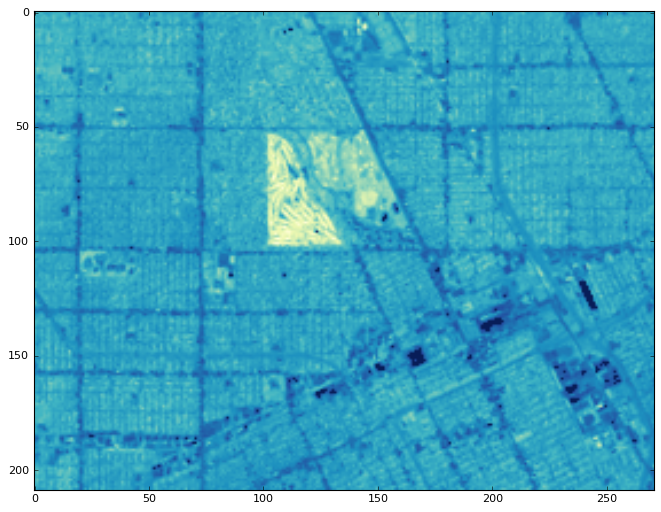

In [2]:
from matplotlib import pyplot as plt, cm
%matplotlib inline

preview_nir = lt5_detroit[3,...]
preview_nir[preview_nir == -9999] = 0 # Remap any NoData values to zero

# Reconfigure the raster array so that the band axis is the third axis
plt.figure(figsize = (10, 10))
plt.imshow(preview_nir, cmap = cm.YlGnBu_r)
plt.show()

We want to transform this image to its minimum noise fraction (MNF) image, prior to extracting our endmember spectra and unmixing.

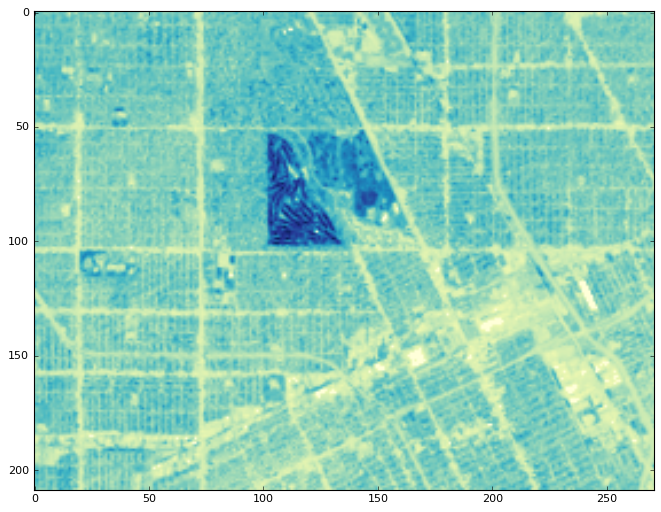

In [3]:
from unmixing.transform import mnf_rotation
mnf = mnf_rotation(lt5_detroit, nodata = -9999)

# The MNF image is returned in HSI form (the transpose of our original raster array)
plt.figure(figsize = (10, 10))
plt.imshow(mnf.T[0,...], cmap = cm.YlGnBu_r)
plt.show()

Base on my outside knowledge of the scene, I can see from both the NIR image and the first MNF band that the golf course in the center of the image shows up quite clearly. We can also easily identify many major surface streets.

## Selecting and Verifying Endmember Locations

Thanks to prior work I've done in this area, I already have a number of potential endmember candidates identified from pseudo-invariant features (PIFs). Below is a map of where the endmember candidates of each type are located. The endmember types are:

- Vegetation (1, colored green)
- High-albedo/ bright substrate (2, colored red)
- Low-albedo/ dark substrate (3, colored blue)

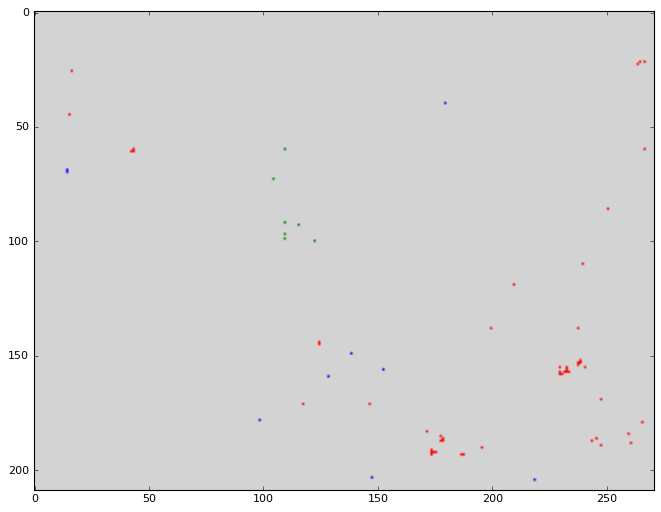

In [4]:
from matplotlib.colors import ListedColormap

pifs, gt0, wkt0 = as_array('data/LT05_020030_merge_19950712_VBD_endmember_PIFs.tiff')

# Create a color map for background (0 = lightgray), vegetation (1 = green), etc...
color_code_map = ListedColormap(['lightgray', 'green', 'red', 'blue'])
plt.figure(figsize = (10, 10))
plt.imshow(pifs[0,...], cmap = color_code_map)
plt.show()

As you can see, we've got a good set of each endmember, but the spatial distribution in each class is such that there are some parts of the image that don't have a nearby pixel of every endmember type. **This can be a problem for a spatially adpative approach with a fixed window size;** if there are no endmember candidates of a given type within a moving window centered on a given pixel, then we can't unmix that pixel.

But first, let's verify that these ground targets correspond with the materials of interest (for a VBD or vegetation-bright-dark endmember model).

In [6]:
import numpy as np
from unmixing.utils import binary_mask

# Use a binary "mask" to mask out MNF pixels *not* associated with the ground target
mnf_veg = binary_mask(mnf.T[0:2,...], np.where(pifs == 1, 1, 0), nodata = -9999, invert = True)
mnf_bright = binary_mask(mnf.T[0:2,...], np.where(pifs == 2, 1, 0), nodata = -9999, invert = True)
mnf_dark = binary_mask(mnf.T[0:2,...], np.where(pifs == 3, 1, 0), nodata = -9999, invert = True)

In [7]:
from unmixing.visualize import FeatureSpace
from unmixing.utils import subarray

# Filter out the masked (NoData) pixels
veg_spectra = subarray(mnf_veg)
bright_spectra = subarray(mnf_bright)
dark_spectra = subarray(mnf_dark)

vis = FeatureSpace('data/LT05_020030_merge_19950712_stack_clip.tiff', 
    transform = True, feature_limit = None, nodata = -9999, cut_dim = 2)

In [ ]:
%matplotlib inline
%config InlineBackend.close_figures=False
vis.plot_feature_space(user_defaults = {'c': '#aaaaaa'})

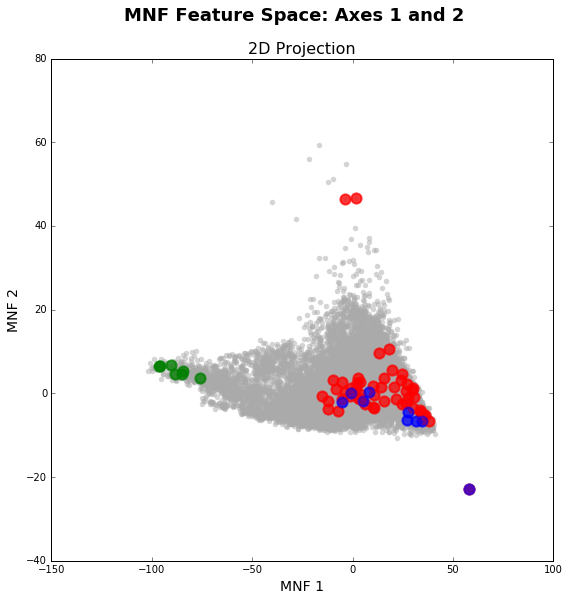

In [13]:
vis.plot_spectral_points(bright_spectra[0:2,...].T, 'r.', alpha = 0.5)
vis.plot_spectral_points(dark_spectra[0:2,...].T, 'b.', alpha = 0.5)
vis.plot_spectral_points(veg_spectra[0:2,...].T, 'g.', alpha = 0.5)
plt.show()

It's apparent that some of the high-albedo/ bright targets are actually quite dark (they're located near the low-albedo/ dark targets). This might be because these bright surfaces are shaded in this image. It might also be that a local mixture space (from a smaller moving window) might be a subset of the overall mixture space, in which the spatially adapted endmembers fall closer to the vertices of the mixing space. At any rate, we'll ignore this problem for the purposes of this example.

## Learning New Endmember Candidates

The overarching problem is the same: We have too few endmember candidates distributed across the geographic space of the image we want to unmix. Following the examples in the literature, we'll learn new endmember candidates using classification and regression trees (CART).

In both Deng and Wu (2013) and Wu et al. (2014), the biophysical composition index (BCI) and normalized difference vegetation index (NDVI) were used as predictive features for learning endmember types.

In [36]:
%config InlineBackend.close_figures=True

from unmixing.sasma import CARTLearner
from unmixing.transform import biophysical_composition_index, ndvi

# Our predictive features
bci_img = biophysical_composition_index(lt5_detroit, nodata = -9999)
ndvi_img = ndvi(lt5_detroit, nodata = -9999)

# Transform the empty labels to NoData (i.e., there is no class 0)
pifs_masked = np.where(pifs == 0, -9999, pifs)

# Fit the classification tree to the known endmember candidates (PIFs)
learner = CARTLearner(pifs_masked, bci_img, ndvi_img)
tree_fit, xarr, yarr = learner.fit_tree(params = {
  'min_samples_leaf': 4,
})

Now, we can ask the classification tree to predict the endmember classes (labels) in all the other pixels in our study area.

In [37]:
prediction = learner.predict()

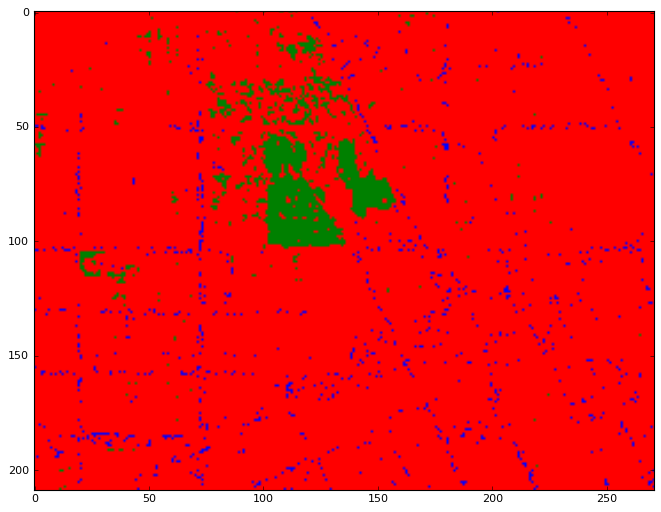

In [39]:
plt.close()
color_code_map = ListedColormap(['green', 'red', 'blue'])
plt.figure(figsize = (10, 10))
plt.imshow(prediction[0,...], cmap = color_code_map)
plt.show()

As a first pass, the vegetation predictions (green color) are pretty good. The dark targets (blue color) also seem reasonable--their high degree of clustering along major roads suggests they are mostly shaded impervious surfaces. The prediction of high-albedo/ bright targets (red color) throughout the image, however, is totally unrealistic.

Let's impose some additional constraints on the high-albedo/ bright targets. Below, we require that bright targets be in the top 10% of tasseled cap (TC) brightness and bottom 50% of tasseled cap greenness.

In [41]:
from unmixing.transform import tasseled_cap_tm

shp = lt5_detroit.shape
tc_img = np.where(lt5_detroit[0:3,...] == -9999, -9999, tasseled_cap_tm(lt5_detroit))\
    .reshape((3, shp[1] * shp[2]))

# Bright targets must be in the top 10% of TC brightness, bottom 50% of TC greenness
from unmixing.lsma import ravel_and_filter
tcb_bright_mask = np.where(np.logical_and(
  prediction.reshape((1, shp[1] * shp[2])) == 2,
  np.logical_and(
      tc_img[0,...] > np.percentile(ravel_and_filter(tc_img[0,...]), 0.90),
      tc_img[1,...] < np.percentile(ravel_and_filter(tc_img[1,...]), 0.50))), 
  1, 0).reshape((1, shp[1], shp[2]))

prediction_cleaned = np.where(np.logical_and(prediction == 2, tcb_bright_mask == 0), 0, prediction)

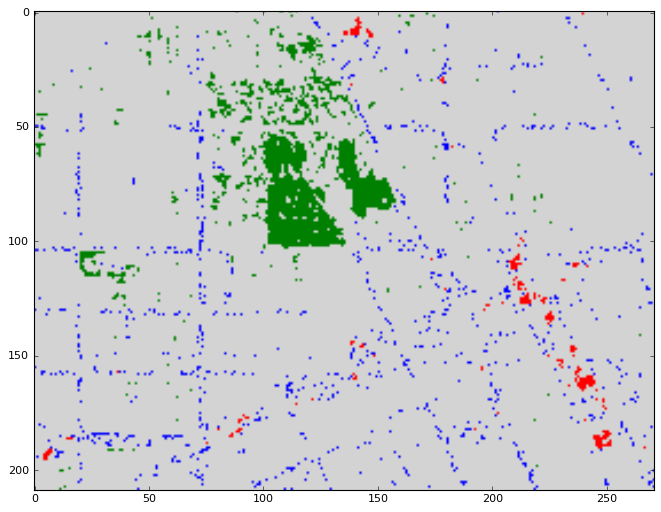

In [43]:
color_code_map = ListedColormap(['lightgray', 'green', 'red', 'blue'])
plt.figure(figsize = (10, 10))
plt.imshow(prediction_cleaned[0,...], cmap = color_code_map)
plt.show()

Now we have a much more realistic looking map of endmember candidates.

## Generating Spatially Interpolated Endmember Spectra

The next step requires us to calculate, for each pixel in the scene, the weighted endmember combinations that will be used to unmix that pixel. We do that here ahead of time, or offline, with respect to the actual spectral mixture analysis. We'll pre-compute the endmember combinations so that we obtain three $(M \times N \times P)$ raster arrays for $P$ spectral bands, one for each endmember type.

In [46]:
from unmixing.sasma import kernel_idw_l1, interpolate_endmember_map

# IMPORTANT: Mask out NoData areas in the endmember candidate map
predicted_pifs = np.where(lt5_detroit[0,...] == -9999, 0, prediction_cleaned)

window = kernel_idw_l1(110, band_num=1)
synth_maps = interpolate_endmember_map(spectra = mnf.T, em_locations = predicted_pifs, 
    window = window, q = 3, n = 3, labels = None, cval = 0, nodata = -9999)

/usr/local/dev/dissertation/unmixing/unmixing/sasma.py:249: RuntimeWarning: invalid value encountered in double_scalars
  np.multiply(np.where(x == cval, 0, 1), window)),


The `interpolate_endmember_map()` function returns a tuple of $Q$ raster arrays, one for each endmember type.

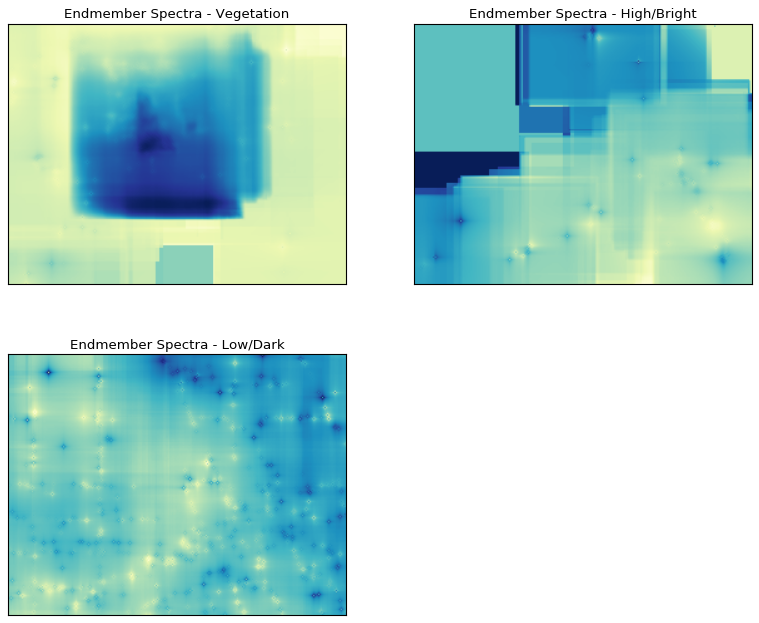

In [83]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace = -0.2)
endmember_labels = ['Vegetation', 'High/Bright', 'Low/Dark']
for i in range(0, 3):
    ax = fig.add_subplot(221 + i, title = 'Endmember Spectra - %s' % endmember_labels[i])
    ax.imshow(synth_maps[i][0,...], cmap = cm.YlGnBu_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Spatially Adaptive Spectral Mixture Analysis

One more decision we have to make is what to do with those pixels that don't have any weighted endmember combinations because there are no endmember candidates within the window. We'll decide to fill them with their band means.

In [48]:
from unmixing.utils import fill_nan_bandwise

emv, emb, emd = synth_maps

# Fill in NaN with band-wise means
emv = fill_nan_bandwise(emv)
emb = fill_nan_bandwise(emb)
emd = fill_nan_bandwise(emd)

**We're now ready to unmix our original image.** The SASMA and LSMA modules in `unmixing` now support multiple processes, so we can get the work done really quickly.

In [80]:
from unmixing.lsma import FCLSAbundanceMapper
from unmixing.sasma import concat_endmember_arrays

# Concatenate VBD endmembers in BVD order (for RGB equivalence)
endmembers = concat_endmember_arrays(emb, emv, emd)
fcls_mapper = FCLSAbundanceMapper(mnf.T, gt, wkt, processes = 4)
result = fcls_mapper.map_abundance(endmembers)

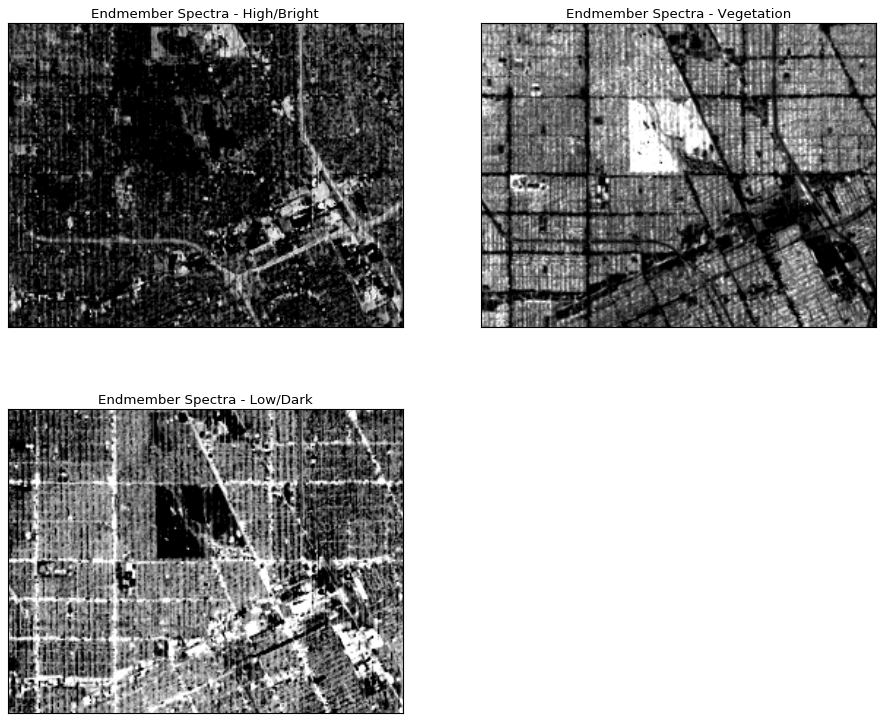

In [86]:
fig = plt.figure(figsize = (14, 14))
fig.subplots_adjust(hspace = -0.2)
endmember_labels = ['High/Bright', 'Vegetation', 'Low/Dark']
for i in range(0, 3):
    ax = fig.add_subplot(221 + i, title = 'Endmember Spectra - %s' % endmember_labels[i])
    ax.imshow(result.T[i,...], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)